<a href="https://colab.research.google.com/github/rlzhang1310/MLProject/blob/main/S%26P500_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.9 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=472f4f838f2be3a2ad55256bacd3619aef62ae6fb068ca45092944a04ec88ee5
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=cc7d6e4a7358e774c16b7d011b8b5d45e8d219b272861c42d8a15e2c590ca8dc
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found existing

In [11]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import time
import math
from datetime import timedelta
from yahoo_fin.stock_info import get_data, tickers_sp500
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

In [12]:
## Main Function which runs a certain stock(string) and stores its estimated value into the map(dict)
## 1. Process/Scrap Data  (get_data -> price -> % change from 7 business days ago -> add last 7 business days)
## 2. Run RNN Model (inputs last 7 business days as the parameter to predict next day)
## 3. Estimates the value of the stock by adding the values of predicted 7 days (basically finding the integral/area)
## 4. Maps expected value into the dictionary

def stock_worth(stock, map):
  df = get_data(stock, start_date=None, end_date='08-29-2023', index_as_date = True, interval="1d")
  df = df[['close']]

  ## Appends Last 7 Business Days onto the df (returns 'windowed_df')
  def df_to_windowed_df(dataframe, first_date, last_date, n=3):

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
      df_subset = dataframe.loc[:target_date].tail(n+1)

      if len(df_subset) != n+1:
        print(f'Error: Window of size {n} is too large for date {target_date} or data does not exist on csv')
        return

      values = df_subset['close'].to_numpy()
      x, y = values[:-1], values[-1]

      dates.append(target_date)
      X.append(x)
      Y.append(y)

      next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
      next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
      next_date_str = next_datetime_str.split('T')[0]
      year_month_day = next_date_str.split('-')
      year, month, day = year_month_day
      next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

      if last_time:
        break

      target_date = next_date

      if target_date == last_date:
        last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
      X[:, i]
      ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

  ## processes windowed_df into right format
  ## returns the dates, X, Y
  def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    # middle_matrix = df_as_np[:, 1:-2] # with percent change

    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)


  # df['date'] = df['date'].apply(str_to_datetime)
  # df['date']

  # df.index = df.pop('date')



  ## data processing

  df_percent = df.copy()

  df_percent['close'] = df_percent['close'].pct_change(periods=7) * 100

  earliest_date = df_percent.index.min()
  latest_date = df_percent.index.max()
  if (len(df_percent.index)) < 15:
    raise Exception("Not enough data, consider adding more")

  min_time_period = timedelta(days=365) * 5 + timedelta(days=14)
  if latest_date - earliest_date > min_time_period:
      earliest_date = latest_date - timedelta(days=365)*5
  else:
      earliest_date = df_percent.index[14]

  windowed_df = df_to_windowed_df(df_percent,
                                  earliest_date,
                                  latest_date,
                                  n=7)

  dates, X, y = windowed_df_to_date_X_y(windowed_df)

  ## data splitting

  q_80 = int(len(dates) * .8)
  q_90 = int(len(dates) * .9)

  dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

  dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
  dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

  ## training model

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)



  model = Sequential([layers.Input((7, 1)),
                      layers.LSTM(64, activation='relu', return_sequences=True),
                      layers.LSTM(128),
                      # layers.Dense(64, activation='relu'),
                      layers.Dense(16, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.0015),
                metrics=['mean_absolute_error'])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[callback])

  ## recursive prediction

  recursive_predictions = []
  recursive_dates = dates_test[-7:]
  # print(recursive_dates)

  def recursive(n, recursive_predictions, recursive_dates):
    last_window = deepcopy(X_train[-1])

    for target_date in recursive_dates:
      next_prediction = model.predict(np.array([last_window])).flatten()
      recursive_predictions.append(next_prediction)
      last_window = np.append(last_window, next_prediction)
      last_window = np.delete(last_window, 0).reshape(-1, 1)
    recursive_predictions[:n]

  recursive(7, recursive_predictions, recursive_dates)

  sum = 0
  for pred in recursive_predictions:
    sum += pred
  map[stock] = sum
  # print(f"Stock Value: {sum}")

In [17]:
## Iterate through stocks and input budget ##

budget = 100000

money = budget
map = {}
invest = set()
portfolio = {}

start_time = time.time()
for stock in tickers_sp500():
  print(stock)
  stock_worth(stock, map)
execution_time = time.time() - start_time


A
Epoch 1/100
32/32 [==============================] - 5s 44ms/step - loss: 13.9448 - mean_absolute_error: 2.8351 - val_loss: 10.4059 - val_mean_absolute_error: 2.5619
Epoch 2/100
32/32 [==============================] - 1s 24ms/step - loss: 6.7946 - mean_absolute_error: 1.9542 - val_loss: 9.0260 - val_mean_absolute_error: 2.3205
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 6.1466 - mean_absolute_error: 1.8209 - val_loss: 8.2715 - val_mean_absolute_error: 2.1910
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 6.1656 - mean_absolute_error: 1.8293 - val_loss: 7.9945 - val_mean_absolute_error: 2.1722
Epoch 5/100
32/32 [==============================] - 1s 23ms/step - loss: 5.7512 - mean_absolute_error: 1.7661 - val_loss: 7.7489 - val_mean_absolute_error: 2.1509
Epoch 6/100
32/32 [==============================] - 1s 23ms/step - loss: 5.7059 - mean_absolute_error: 1.7713 - val_loss: 8.5766 - val_mean_absolute_error: 2.2474
Epoch 7/100


/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


Epoch 1/100
32/32 [==============================] - 6s 61ms/step - loss: 12.7242 - mean_absolute_error: 2.5841 - val_loss: 8.5917 - val_mean_absolute_error: 2.4010
Epoch 2/100
32/32 [==============================] - 1s 35ms/step - loss: 5.9235 - mean_absolute_error: 1.7729 - val_loss: 6.4091 - val_mean_absolute_error: 2.0165
Epoch 3/100
32/32 [==============================] - 1s 29ms/step - loss: 4.8353 - mean_absolute_error: 1.5827 - val_loss: 5.7858 - val_mean_absolute_error: 1.8401
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 4.4110 - mean_absolute_error: 1.5197 - val_loss: 5.6419 - val_mean_absolute_error: 1.8550
Epoch 5/100
32/32 [==============================] - 1s 23ms/step - loss: 4.4831 - mean_absolute_error: 1.5281 - val_loss: 6.3808 - val_mean_absolute_error: 1.9150
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss: 4.7612 - mean_absolute_error: 1.5842 - val_loss: 5.7952 - val_mean_absolute_error: 1.8610
Epoch 7/100
1/1

/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step
META
Epoch 1/100
32/32 [==============================] - 6s 58ms/step - loss: 29.9415 - mean_absolute_error: 4.0449 - val_loss: 80.9563 - val_mean_absolute_error: 6.1563
Epoch 2/100
32/32 [==============================] - 1s 35ms/step - loss: 15.1880 - mean_absolute_error: 2.7958 - val_loss: 62.4399 - val_mean_absolute_error: 5.3802
Epoch 3/100
32/32 [==============================] - 1s 41ms/step - loss: 13.1207 - mean_absolute_error: 2.6257 - val_loss: 58.1169 - val_mean_absolute_error: 5.3573
Epoch 4/100
32/32 [==============================] - 1s 40ms/step - loss: 12.6502 - mean_absolute_error: 2.6095 - val_loss: 55.0002 - val_mean_absolute_error: 5.1741
Epoch 5/100
32/32 [==============================] - 1s 38ms/step - loss: 11.8577 - mean_absolute_error: 2.4867 - val_loss: 52.1686 - val_mean_absolute_error: 5.1161
Epoch 6/100
32/32 [==============================] - 1s 44ms/s

In [28]:
## TESTER ##

money = 100000
portfolio = {}
invest = set()

In [29]:
## invest based on the poportion of stock value ##

print(f"Time taken to train: {math.floor(execution_time / 3600)} hours {math.floor(execution_time % 3600 / 60)} minutes {execution_time % 60} seconds")
poportion = 0
print(map)
tester = 0
for name, value in map.items():
  if value > 0.7:
    invest.add(name)
    poportion += value

for stock in invest:
  tester += map[stock]
  invest_amount = np.round((map[stock] / poportion) * budget, 2)
  print(f"stocks invest: {stock}, amount: {invest_amount}")
  money -= invest_amount
  portfolio[stock] = invest_amount
print(money)
print(f"poportion: {poportion}, tester: {tester}")
print(portfolio)
# validate = money
# for name, value in portfolio.items():
#   validate += value
# print(f"validate add up: {validate}")


Time taken to train: 2 hours 31 minutes 49.08090925216675 seconds
{'A': array([-29.2785], dtype=float32), 'AAL': array([-64.14946], dtype=float32), 'AAPL': array([-28.233118], dtype=float32), 'ABBV': array([-17.021849], dtype=float32), 'ABT': array([-33.333096], dtype=float32), 'ACGL': array([-7.845554], dtype=float32), 'ACN': array([-5.5168653], dtype=float32), 'ADBE': array([-31.252531], dtype=float32), 'ADI': array([-13.286661], dtype=float32), 'ADM': array([20.000885], dtype=float32), 'ADP': array([-4.8842235], dtype=float32), 'ADSK': array([-84.07257], dtype=float32), 'AEE': array([-17.285461], dtype=float32), 'AEP': array([-14.607848], dtype=float32), 'AES': array([13.124088], dtype=float32), 'AFL': array([4.1657295], dtype=float32), 'AIG': array([3.9069276], dtype=float32), 'AIZ': array([-12.283316], dtype=float32), 'AJG': array([-12.913281], dtype=float32), 'AKAM': array([-11.372746], dtype=float32), 'ALB': array([0.9934178], dtype=float32), 'ALGN': array([2.2234864], dtype=flo

In [30]:
## Validate simulated portfolio ##

portfolio_value = money
for stock, value in portfolio.items():
  df = get_data(stock, start_date='2023-08-29 00:00:00', end_date='2023-09-10 00:00:00', index_as_date = True, interval="1d")

  profit = df['close'][-1] - df['close'][0]
  print(f"profit per stock: {profit}")
  profit_percent = profit / df['close'][0]
  print(f"profit percent: {profit_percent}")
  portfolio[stock] = np.round((1 + profit_percent) * value, 2)

for name, value in portfolio.items():
  portfolio_value += value
print('-' * 40)
print(f"portfolio_value is: {portfolio_value}")


profit per stock: -2.100006103515625
profit percent: -0.010067143058823873
profit per stock: 11.020004272460938
profit percent: 0.05942304909035153
profit per stock: 1.600006103515625
profit percent: 0.008810121128453025
profit per stock: -7.70001220703125
profit percent: -0.01727273393175506
profit per stock: -11.639999389648438
profit percent: -0.05209451871851304
profit per stock: -12.150001525878906
profit percent: -0.10211801296920085
profit per stock: -0.149993896484375
profit percent: -0.0013642010063445755
profit per stock: 7.25
profit percent: 0.0453238290554003
profit per stock: -2.9499969482421875
profit percent: -0.020124135493137137
profit per stock: -1.790008544921875
profit percent: -0.004560531324641719
profit per stock: -1.80999755859375
profit percent: -0.0056162267762489
profit per stock: -1.0800018310546875
profit percent: -0.03289679472491189
profit per stock: 3.7699966430664062
profit percent: 0.037482566856569664
profit per stock: 2.7899932861328125
profit percen

## In order to compare our performance, we can analyze how well our model did compared to simply investing in S&P500

In [32]:
df = get_data('^GSPC', start_date='2023-08-29 00:00:00', end_date='2023-09-10 00:00:00', index_as_date = True, interval="1d")
print(df)
profit = df['close'][-1] - df['close'][0]
print(f"profit per stock: {profit}")
profit_percent = profit / df['close'][0]
print(f"profit percent: {profit_percent}")
sp = np.round((1 + profit_percent) * budget, 2)
print(f"S&P500 investment: {sp}")


                   open         high          low        close     adjclose  \
2023-08-29  4432.750000  4500.140137  4431.680176  4497.629883  4497.629883   
2023-08-30  4500.339844  4521.649902  4493.589844  4514.870117  4514.870117   
2023-08-31  4517.009766  4532.259766  4507.390137  4507.660156  4507.660156   
2023-09-01  4530.600098  4541.250000  4501.350098  4515.770020  4515.770020   
2023-09-05  4510.060059  4514.290039  4496.009766  4496.830078  4496.830078   
2023-09-06  4490.350098  4490.350098  4442.379883  4465.479980  4465.479980   
2023-09-07  4434.549805  4457.810059  4430.459961  4451.140137  4451.140137   
2023-09-08  4451.299805  4473.529785  4448.379883  4457.490234  4457.490234   

                volume ticker  
2023-08-29  3354820000  ^GSPC  
2023-08-30  3064110000  ^GSPC  
2023-08-31  3946360000  ^GSPC  
2023-09-01  3246260000  ^GSPC  
2023-09-05  3526250000  ^GSPC  
2023-09-06  3418850000  ^GSPC  
2023-09-07  3763760000  ^GSPC  
2023-09-08  3259290000  ^GSPC  


In [35]:
## Overall, our model is making profit while the S&P500 that specific month was losing money

print(f"In general, our model is making {(portfolio_value - sp) / budget * 100}% more than simply investing in S&P500")

In general, our model is making [1.2514]% more than simply investing in S&P500


# ALL the code below is used to run individual stocks/graph out

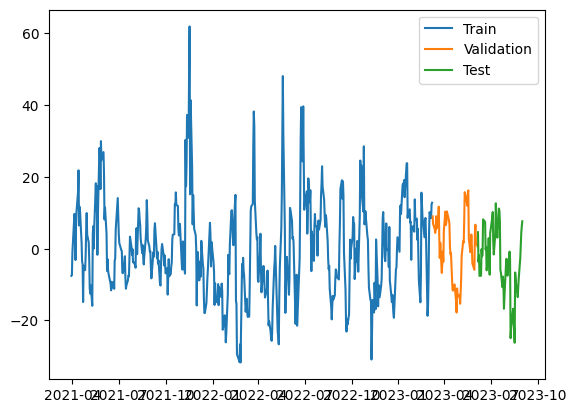

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)



model = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64, activation='relu', return_sequences=True),
                    layers.LSTM(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0015),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[callback])

test_loss, test_mae = model.evaluate(X_test, y_test)

print("Test Mean Squared Error:", test_loss)
print("Test Mean Absolute Error:", test_mae)

Epoch 1/100
16/16 [==============================] - 12s 105ms/step - loss: 163.6735 - mean_absolute_error: 9.8354 - val_loss: 46.9100 - val_mean_absolute_error: 5.8636
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 96.0981 - mean_absolute_error: 7.3578 - val_loss: 21.5278 - val_mean_absolute_error: 3.6625
Epoch 3/100
16/16 [==============================] - 0s 24ms/step - loss: 70.8077 - mean_absolute_error: 6.2271 - val_loss: 20.3151 - val_mean_absolute_error: 3.6738
Epoch 4/100
16/16 [==============================] - 0s 24ms/step - loss: 65.6927 - mean_absolute_error: 5.9658 - val_loss: 19.1041 - val_mean_absolute_error: 3.3615
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 58.9802 - mean_absolute_error: 5.6747 - val_loss: 19.4358 - val_mean_absolute_error: 3.4609
Epoch 6/100
16/16 [==============================] - 0s 25ms/step - loss: 57.5986 - mean_absolute_error: 5.6501 - val_loss: 16.2350 - val_mean_absolute_error: 3.2327
E

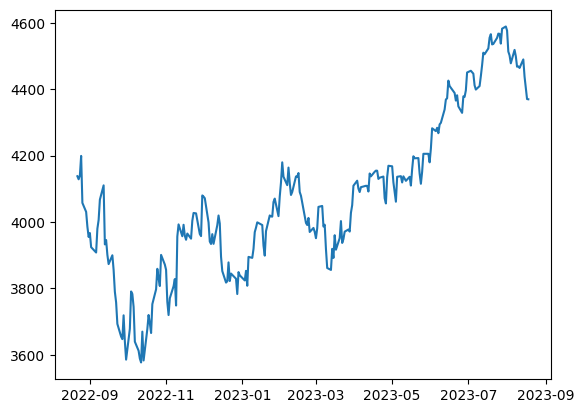

In [ ]:
# @title
# import matplotlib.pyplot as plt

# plt.plot(df.index, df['Close'])

32/32 [==============================] - 1s 5ms/step


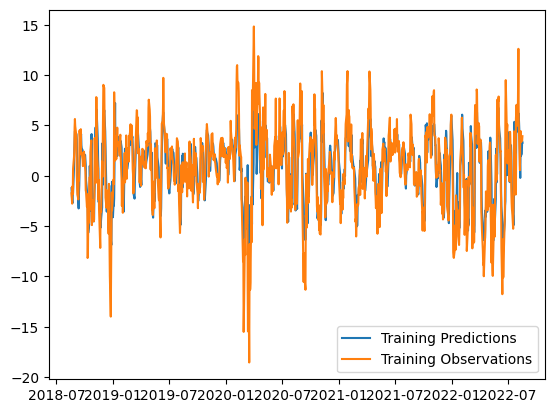

In [ ]:
# @title
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 1s 14ms/step


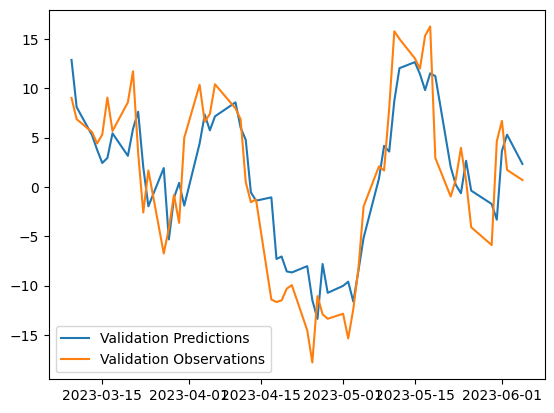

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 16ms/step


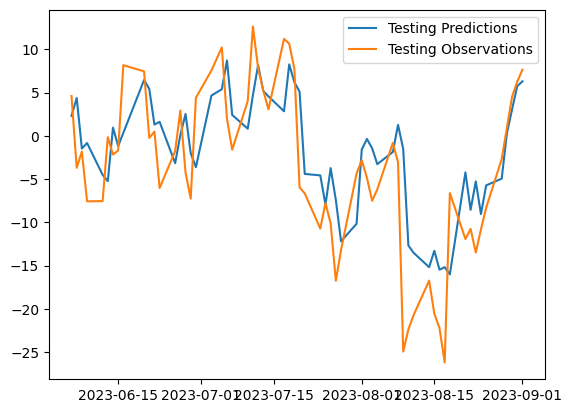

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

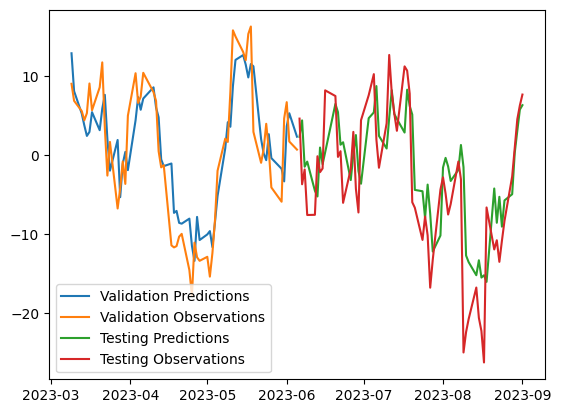

In [ ]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend([
            # 'Training Predictions',
            # 'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

TODO: change to predict by percentage change (in a month/week?)

TODO: create model that works with other stocks as well, then create a function that will use the predicted values to trade

In [ ]:
from copy import deepcopy

recursive_predictions = []
# recursive_dates = np.concatenate([dates_val, dates_test])[:14]
recursive_dates = dates_test[:7]

def recursive(n, recursive_predictions, recursive_dates):
  last_window = deepcopy(X_train[-1])

  for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window = np.append(last_window, next_prediction)
    last_window = np.delete(last_window, 0).reshape(-1, 1)
  recursive_predictions[:n]

recursive(7, recursive_predictions, recursive_dates)


1/1 [==============================] - 0s 29ms/step


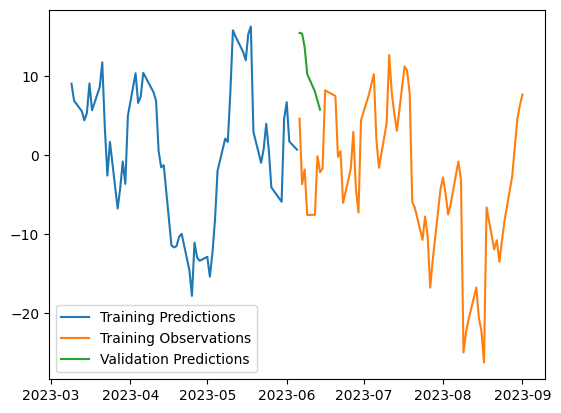

In [ ]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
# plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
# plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])